### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [16]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [17]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [18]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(pd.DataFrame(dataset['train']))
test_dataset = preprocess(pd.DataFrame(dataset['test']))
val_dataset = preprocess(pd.DataFrame(dataset['validation']))

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [19]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [20]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [21]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [22]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x16de2f880>, 'text': <torchtext.data.field.Field object at 0x16de2f8e0>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [23]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [24]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [25]:
import random
import os
import numpy as np

from transformers import BertModel

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = torch.from_numpy(model.embeddings.word_embeddings.weight.detach().numpy())
embedding_matrix.shape

torch.Size([30522, 768])

In [26]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [27]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [28]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [29]:
import math

EMBEDDING_DIM = 768
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 50
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Total training loss: 28.684881567955017
Training performance: (0.81065, 0.81065, 0.81065, None)
Total development loss: 2.484216094017029
Development performance: (0.8522, 0.8522, 0.8522, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:08<00:00,  4.04it/s]


Total training loss: 22.9529350399971
Training performance: (0.824275, 0.824275, 0.824275, None)
Total development loss: 2.4247028827667236
Development performance: (0.8522, 0.8522, 0.8522, None)


Epoch 2: 100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Total training loss: 22.271428257226944
Training performance: (0.82415, 0.82415, 0.82415, None)
Total development loss: 2.40483695268631
Development performance: (0.8524, 0.8524, 0.8524, None)
Saving model.


Epoch 3: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Total training loss: 21.6667577624321
Training performance: (0.823075, 0.823075, 0.823075, None)
Total development loss: 2.4048272371292114
Development performance: (0.8514, 0.8514, 0.8514, None)


Epoch 4: 100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


Total training loss: 21.271485924720764
Training performance: (0.822675, 0.822675, 0.822675, None)
Total development loss: 2.371514320373535
Development performance: (0.8512, 0.8512, 0.8512, None)


Epoch 5: 100%|██████████| 34/34 [00:08<00:00,  4.04it/s]


Total training loss: 20.817978024482727
Training performance: (0.822725, 0.822725, 0.822725, None)
Total development loss: 2.3383973836898804
Development performance: (0.8506, 0.8506, 0.8506, None)


Epoch 6: 100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Total training loss: 20.212081402540207
Training performance: (0.823975, 0.823975, 0.823975, None)
Total development loss: 2.304509401321411
Development performance: (0.8514, 0.8514, 0.8514, None)


Epoch 7: 100%|██████████| 34/34 [00:08<00:00,  4.00it/s]


Total training loss: 18.765037536621094
Training performance: (0.82705, 0.82705, 0.82705, None)
Total development loss: 2.100227862596512
Development performance: (0.8556, 0.8556, 0.8556, None)
Saving model.


Epoch 8: 100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Total training loss: 16.55338528752327
Training performance: (0.84205, 0.84205, 0.84205, None)
Total development loss: 1.9887425899505615
Development performance: (0.8532, 0.8532, 0.8532, None)


Epoch 9: 100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Total training loss: 15.663593888282776
Training performance: (0.8483, 0.8483, 0.8483, None)
Total development loss: 1.8240146040916443
Development performance: (0.862, 0.862, 0.862, None)
Saving model.


Epoch 10: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Total training loss: 14.628508538007736
Training performance: (0.858625, 0.858625, 0.858625, None)
Total development loss: 1.8118312358856201
Development performance: (0.8694, 0.8694, 0.8694, None)
Saving model.


Epoch 11: 100%|██████████| 34/34 [00:08<00:00,  4.24it/s]


Total training loss: 13.91353166103363
Training performance: (0.861375, 0.861375, 0.861375, None)
Total development loss: 1.7197977602481842
Development performance: (0.8702, 0.8702, 0.8702, None)
Saving model.


Epoch 12: 100%|██████████| 34/34 [00:10<00:00,  3.27it/s]


Total training loss: 13.363298386335373
Training performance: (0.865875, 0.865875, 0.865875, None)
Total development loss: 1.6652860045433044
Development performance: (0.8774, 0.8774, 0.8774, None)
Saving model.


Epoch 13: 100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Total training loss: 12.81931558251381
Training performance: (0.86835, 0.86835, 0.86835, None)
Total development loss: 1.6746528148651123
Development performance: (0.8706, 0.8706, 0.8706, None)


Epoch 14: 100%|██████████| 34/34 [00:10<00:00,  3.27it/s]


Total training loss: 12.004950135946274
Training performance: (0.878775, 0.878775, 0.878775, None)
Total development loss: 1.624165803194046
Development performance: (0.8758, 0.8758, 0.8758, None)


Epoch 15: 100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Total training loss: 11.541446089744568
Training performance: (0.8838, 0.8838, 0.8838, None)
Total development loss: 1.6486070454120636
Development performance: (0.8704, 0.8704, 0.8704, None)


Epoch 16: 100%|██████████| 34/34 [00:08<00:00,  4.09it/s]


Total training loss: 10.823284953832626
Training performance: (0.890125, 0.890125, 0.890125, None)
Total development loss: 1.5608026683330536
Development performance: (0.879, 0.879, 0.879, None)
Saving model.


Epoch 17: 100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Total training loss: 10.461276218295097
Training performance: (0.8934, 0.8934, 0.8934, None)
Total development loss: 1.7748188376426697
Development performance: (0.865, 0.865, 0.865, None)


Epoch 18: 100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Total training loss: 10.565605610609055
Training performance: (0.88975, 0.88975, 0.88975, None)
Total development loss: 1.6054131090641022
Development performance: (0.8788, 0.8788, 0.8788, None)


Epoch 19: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Total training loss: 9.711514562368393
Training performance: (0.9001, 0.9001, 0.9001, None)
Total development loss: 1.7697063088417053
Development performance: (0.8686, 0.8686, 0.8686, None)


Epoch 20: 100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Total training loss: 9.35351811349392
Training performance: (0.90365, 0.90365, 0.90365, None)
Total development loss: 1.693349689245224
Development performance: (0.876, 0.876, 0.876, None)


Epoch 21: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Total training loss: 8.842972457408905
Training performance: (0.907575, 0.907575, 0.907575, None)
Total development loss: 1.6506398618221283
Development performance: (0.8772, 0.8772, 0.8772, None)


Epoch 22: 100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Total training loss: 8.814296633005142
Training performance: (0.907825, 0.907825, 0.907825, None)
Total development loss: 1.7448642253875732
Development performance: (0.8744, 0.8744, 0.8744, None)


Epoch 23: 100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Total training loss: 8.129788935184479
Training performance: (0.916525, 0.916525, 0.916525, None)
Total development loss: 1.7067260444164276
Development performance: (0.8786, 0.8786, 0.8786, None)


Epoch 24: 100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Total training loss: 7.761657640337944
Training performance: (0.918775, 0.918775, 0.918775, None)
Total development loss: 1.6840358972549438
Development performance: (0.8786, 0.8786, 0.8786, None)


Epoch 25: 100%|██████████| 34/34 [00:08<00:00,  4.06it/s]


Total training loss: 7.9179606437683105
Training performance: (0.918125, 0.918125, 0.918125, None)
Total development loss: 1.7291575968265533
Development performance: (0.8764, 0.8764, 0.8764, None)


Epoch 26: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Total training loss: 7.439732074737549
Training performance: (0.92165, 0.92165, 0.92165, None)
Total development loss: 1.72095587849617
Development performance: (0.877, 0.877, 0.877, None)


Epoch 27: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Total training loss: 6.994140192866325
Training performance: (0.926575, 0.926575, 0.926575, None)
Total development loss: 1.9161923229694366
Development performance: (0.8738, 0.8738, 0.8738, None)


Epoch 28: 100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Total training loss: 6.717499040067196
Training performance: (0.9294, 0.9294, 0.9294, None)
Total development loss: 1.7081354856491089
Development performance: (0.8746, 0.8746, 0.8746, None)


Epoch 29: 100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Total training loss: 6.299682624638081
Training performance: (0.934475, 0.934475, 0.934475, None)
Total development loss: 2.0248599648475647
Development performance: (0.8732, 0.8732, 0.8732, None)


Epoch 30: 100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


Total training loss: 6.134980030357838
Training performance: (0.934075, 0.934075, 0.934075, None)
Total development loss: 1.9169627726078033
Development performance: (0.8726, 0.8726, 0.8726, None)


Epoch 31: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Total training loss: 5.861150220036507
Training performance: (0.937825, 0.937825, 0.937825, None)
Total development loss: 1.917218029499054
Development performance: (0.8744, 0.8744, 0.8744, None)


Epoch 32: 100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Total training loss: 5.3975720256567
Training performance: (0.94275, 0.94275, 0.94275, None)
Total development loss: 1.951207548379898
Development performance: (0.8784, 0.8784, 0.8784, None)


Epoch 33: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Total training loss: 5.2362708523869514
Training performance: (0.945025, 0.945025, 0.945025, None)
Total development loss: 1.9175837337970734
Development performance: (0.8784, 0.8784, 0.8784, None)


Epoch 34: 100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Total training loss: 5.159381300210953
Training performance: (0.9448, 0.9448, 0.9448, None)
Total development loss: 1.992217868566513
Development performance: (0.8706, 0.8706, 0.8706, None)


Epoch 35: 100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Total training loss: 5.050306022167206
Training performance: (0.946275, 0.946275, 0.946275, None)
Total development loss: 1.9139976799488068
Development performance: (0.8754, 0.8754, 0.8754, None)


Epoch 36: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Total training loss: 4.668412879109383
Training performance: (0.949475, 0.949475, 0.949475, None)
Total development loss: 1.9964494407176971
Development performance: (0.878, 0.878, 0.878, None)


Epoch 37: 100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Total training loss: 4.481693089008331
Training performance: (0.951625, 0.951625, 0.951625, None)
Total development loss: 1.9633154273033142
Development performance: (0.8762, 0.8762, 0.8762, None)


Epoch 38: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s]


Total training loss: 4.240557130426168
Training performance: (0.954725, 0.954725, 0.954725, None)
Total development loss: 2.040413111448288
Development performance: (0.8776, 0.8776, 0.8776, None)


Epoch 39: 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]


Total training loss: 4.020209953188896
Training performance: (0.9561, 0.9561, 0.9561, None)
Total development loss: 2.1020311415195465
Development performance: (0.8774, 0.8774, 0.8774, None)


Epoch 40: 100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Total training loss: 3.801711406558752
Training performance: (0.958125, 0.958125, 0.958125, None)
Total development loss: 2.2787244617938995
Development performance: (0.876, 0.876, 0.876, None)


Epoch 41: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Total training loss: 3.928449496626854
Training performance: (0.95695, 0.95695, 0.95695, None)
Total development loss: 2.0942113995552063
Development performance: (0.8762, 0.8762, 0.8762, None)


Epoch 42: 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]


Total training loss: 4.021491028368473
Training performance: (0.95405, 0.95405, 0.95405, None)
Total development loss: 2.1359095871448517
Development performance: (0.8766, 0.8766, 0.8766, None)


Epoch 43: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Total training loss: 3.6814138405025005
Training performance: (0.959075, 0.959075, 0.959075, None)
Total development loss: 2.15310001373291
Development performance: (0.8776, 0.8776, 0.8776, None)


Epoch 44: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Total training loss: 3.6032169088721275
Training performance: (0.95965, 0.95965, 0.95965, None)
Total development loss: 2.2473506033420563
Development performance: (0.8788, 0.8788, 0.8788, None)


Epoch 45: 100%|██████████| 34/34 [00:05<00:00,  6.79it/s]


Total training loss: 3.513028599321842
Training performance: (0.961125, 0.961125, 0.961125, None)
Total development loss: 2.131641983985901
Development performance: (0.8724, 0.8724, 0.8724, None)


Epoch 46: 100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


Total training loss: 3.2226594872772694
Training performance: (0.965325, 0.965325, 0.965325, None)
Total development loss: 2.3174156546592712
Development performance: (0.8762, 0.8762, 0.8762, None)


Epoch 47: 100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Total training loss: 3.0586997978389263
Training performance: (0.966075, 0.966075, 0.966075, None)
Total development loss: 2.249110460281372
Development performance: (0.8726, 0.8726, 0.8726, None)


Epoch 48: 100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


Total training loss: 2.824396599084139
Training performance: (0.9691, 0.9691, 0.9691, None)
Total development loss: 2.496510922908783
Development performance: (0.8744, 0.8744, 0.8744, None)


Epoch 49: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Total training loss: 2.8705706037580967
Training performance: (0.966425, 0.966425, 0.966425, None)
Total development loss: 2.343228340148926
Development performance: (0.8686, 0.8686, 0.8686, None)


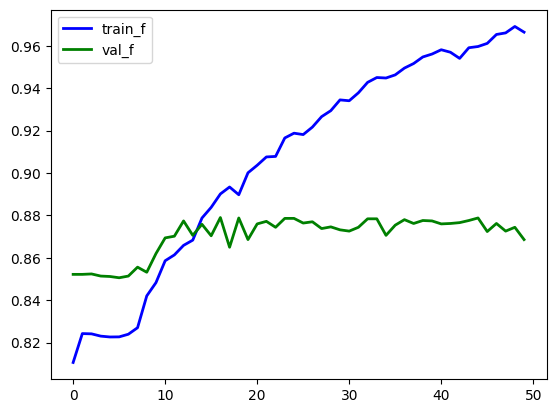

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [31]:
%load_ext tensorboard

In [32]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(30522, 768)
  (lstm): LSTM(768, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [33]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.78      0.29      0.43       270
        I-LF       0.56      0.41      0.47       288
        B-LF       0.35      0.15      0.21       150
         B-O       0.90      0.98      0.94      4292

    accuracy                           0.88      5000
   macro avg       0.65      0.46      0.51      5000
weighted avg       0.86      0.88      0.86      5000



In [34]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.BLACK, 1: Back.RED, 2: Back.GREEN, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")